In [ ]:
!ls -lh


total 4.0K
-rw-r--r-- 1 root root    0 Nov  1 01:39 IDD_Detection.tar.gz
drwxr-xr-x 1 root root 4.0K Oct 30 13:36 sample_data


In [ ]:
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/idd_dataset
!tar -xvzf /content/drive/MyDrive/idd-detection.tar.gz -C /content/idd_dataset --checkpoint=.1000


Streaming output truncated to the last 5000 lines.
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/000780_r.xml
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/000414_r.xml
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/000792_r.xml
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/0000420.xml
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/0001500.xml
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/000690_r.xml
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/0007260.xml
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/000612_r.xml
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/000408_r.xml
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/000180_r.xml
IDD_Detection/Annotations/sideRight/BLR-2018-04-16_15-44-27_sideRight/000318_r.xml
IDD_Detection/Annotations/sideRight/BLR

In [ ]:
!pip install -U ultralytics
from ultralytics import YOLO, checks  # Import checks here

# Call the checks() function directly
checks()

# You can now proceed to use the YOLO class as intended
# model = YOLO('yolov8n.pt')

Ultralytics 8.3.224 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 62.2/112.6 GB disk)


In [ ]:
import os, random, shutil

base = "/content/idd_dataset/IDD_Detection"
images_dir = os.path.join(base, "JPEGImages")
ann_dir = os.path.join(base, "Annotations")

splits = ["train", "val", "test"]
split_ratios = [0.8, 0.1, 0.1]

# create output folders
for split in splits:
    for sub in ["images", "annotations"]:
        os.makedirs(os.path.join(base, split, sub), exist_ok=True)

# collect all images recursively
all_images = []
for root, dirs, files in os.walk(images_dir):
    for f in files:
        if f.endswith(".jpg"):
            img_path = os.path.join(root, f)
            ann_path = img_path.replace("JPEGImages", "Annotations").replace(".jpg", ".xml")
            if os.path.exists(ann_path):
                all_images.append((img_path, ann_path))

print(f" Found {len(all_images)} image-annotation pairs")

random.shuffle(all_images)
n = len(all_images)
train_end = int(n * split_ratios[0])
val_end = train_end + int(n * split_ratios[1])

splits_data = {
    "train": all_images[:train_end],
    "val": all_images[train_end:val_end],
    "test": all_images[val_end:]
}

for split, pairs in splits_data.items():
    for img_path, ann_path in pairs:
        shutil.copy(img_path, os.path.join(base, split, "images"))
        shutil.copy(ann_path, os.path.join(base, split, "annotations"))
    print(f" Copied {len(pairs)} files to {split}")

print(" Dataset split and structured successfully!")


✅ Found 41857 image-annotation pairs
✅ Copied 33485 files to train
✅ Copied 4185 files to val
✅ Copied 4187 files to test
✅ Dataset split and structured successfully!


In [ ]:
!pip install lxml tqdm

import os
from xml.etree import ElementTree as ET
from tqdm import tqdm

classes = [
    "car", "bus", "truck", "motorbike", "bicycle", "autorickshaw",
    "pedestrian", "animal", "traffic light", "traffic sign",
    "road barrier", "building", "pole", "tree", "road", "sky"
]

def convert_bbox(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x = (box[0] + box[1]) / 2.0 - 1
    y = (box[2] + box[3]) / 2.0 - 1
    w, h = box[1] - box[0], box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

def convert_annotations(split_folder):
    img_dir = os.path.join(base, split_folder, "images")
    ann_dir = os.path.join(base, split_folder, "annotations")
    lbl_dir = os.path.join(base, split_folder, "labels")
    os.makedirs(lbl_dir, exist_ok=True)

    for xml_file in tqdm(os.listdir(ann_dir)):
        if not xml_file.endswith(".xml"): continue
        xml_path = os.path.join(ann_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        txt_path = os.path.join(lbl_dir, xml_file.replace(".xml", ".txt"))
        with open(txt_path, "w") as out_file:
            for obj in root.iter("object"):
                cls_name = obj.find("name").text
                if cls_name not in classes:
                    continue
                cls_id = classes.index(cls_name)
                xmlbox = obj.find("bndbox")
                b = (
                    float(xmlbox.find("xmin").text),
                    float(xmlbox.find("xmax").text),
                    float(xmlbox.find("ymin").text),
                    float(xmlbox.find("ymax").text)
                )
                bb = convert_bbox((w, h), b)
                out_file.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")

for split in ["train", "val", "test"]:
    convert_annotations(split)

print(" XML converted to YOLO TXT successfully!")


100%|██████████| 1625/1625 [00:00<00:00, 2671.99it/s]

✅ XML converted to YOLO TXT successfully!


In [ ]:
import yaml

yaml_path = os.path.join(base, "idd.yaml")
data = {
    "train": os.path.join(base, "train", "images"),
    "val": os.path.join(base, "val", "images"),
    "test": os.path.join(base, "test", "images"),
    "nc": 16,
    "names": [
        "car", "bus", "truck", "motorbike", "bicycle", "autorickshaw",
        "pedestrian", "animal", "traffic light", "traffic sign",
        "road barrier", "building", "pole", "tree", "road", "sky"
    ]
}

with open(yaml_path, "w") as f:
    yaml.dump(data, f)
print(" YAML created at:", yaml_path)


✅ YAML created at: /content/idd_dataset/IDD_Detection/idd.yaml


In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")
model.train(
    data=f"{base}/idd.yaml",
    epochs=50,
    imgsz=640,
    batch=8
)


Ultralytics 8.3.224 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/idd_dataset/IDD_Detection/idd.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b14a1fa6ed0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [ ]:
# Copy the model to drive
import shutil

# path where YOLO saved the model
best_model_path = "/content/runs/detect/train/weights/best.pt"

# path in your Google Drive
drive_save_path = "/content/drive/MyDrive/best_idd_model.pt"

# copy it
shutil.copy(best_model_path, drive_save_path)

print(f" Model saved to: {drive_save_path}")


✅ Model saved to: /content/drive/MyDrive/best_idd_model.pt


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train/weights/best.pt")  # or path to your fine-tuned model


In [ ]:
results = model.predict(
    source="/content/idd_dataset/IDD_Detection/test/images",  # or path to a folder/video
    conf=0.25,        # confidence threshold
    save=True,        # saves annotated results to runs/detect/predict/
    show=False,       # disable GUI display in Colab
)



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1625 /content/idd_dataset/IDD_Detection/test/images/0000010.jpg: 384x640 4 cars, 1 bus, 1 autorickshaw, 1 traffic sign, 45.8ms
image 2/1625 /content/idd_dataset/IDD_Detection/test/images/0000012.jpg: 384x640 4 cars, 3 buss, 1 truck, 6.9ms
image 3/1625 /content/idd_dataset/IDD_Detection/test/images/0000013.jpg: 384x640 16 cars, 1 bus, 1 truck, 1 autorickshaw, 1 traffic sign, 6.4ms
image 4/1625 /content/idd_dataset/IDD_Detection/test/images/00000

Saving traffic.jpg to traffic (1).jpg

✅ Uploaded image: traffic (1).jpg


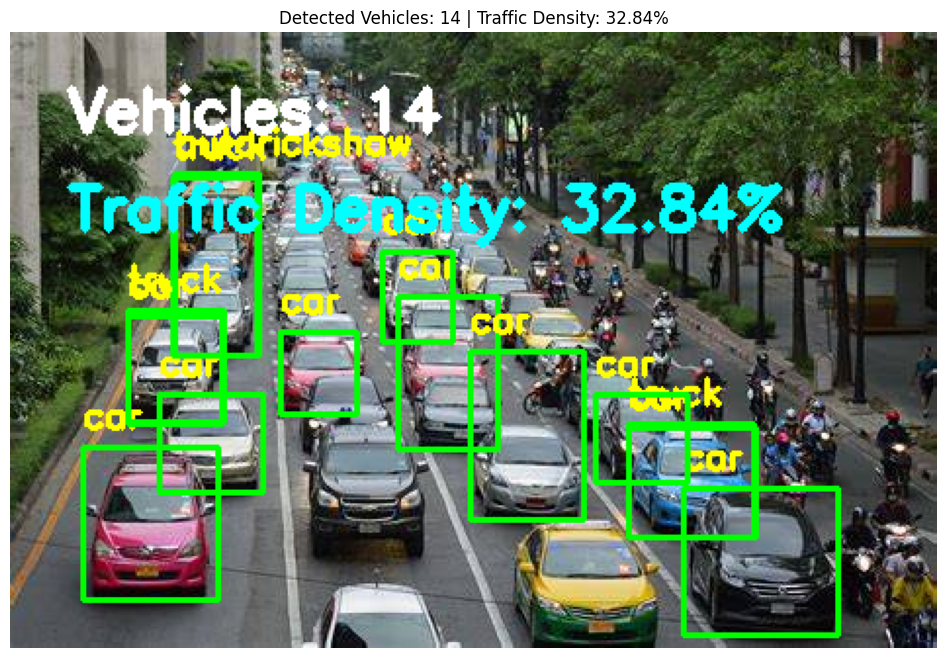

In [ ]:
# ============================================================
# 🚦 Traffic Density Estimation on an Uploaded Image
# ============================================================

!pip install ultralytics opencv-python matplotlib -q

from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 🔹 Step 1: Upload your image
uploaded = files.upload()

# Get the uploaded file path
image_path = list(uploaded.keys())[0]
print(f"\n Uploaded image: {image_path}")

# 🔹 Step 2: Load your trained YOLO model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# 🔹 Step 3: Define vehicle classes
vehicle_classes = ['car', 'bus', 'truck', 'motorbike', 'bicycle', 'autorickshaw']

# 🔹 Step 4: Read the uploaded image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

# 🔹 Step 5: Run YOLO inference
results = model(img_rgb, verbose=False)
boxes = results[0].boxes
names = model.names

# 🔹 Step 6: Compute total vehicle area + count
total_vehicle_area = 0
vehicle_count = 0

for box in boxes:
    cls_id = int(box.cls[0])
    label = names[cls_id]
    if label in vehicle_classes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        total_vehicle_area += (x2 - x1) * (y2 - y1)
        vehicle_count += 1
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_rgb, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2)

# 🔹 Step 7: Calculate traffic density
frame_area = h * w
density = (total_vehicle_area / frame_area) * 100

# 🔹 Step 8: Overlay stats
cv2.putText(img_rgb, f"Vehicles: {vehicle_count}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
cv2.putText(img_rgb, f"Traffic Density: {density:.2f}%", (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 3)

# 🔹 Step 9: Display the output
plt.figure(figsize=(12,8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Detected Vehicles: {vehicle_count} | Traffic Density: {density:.2f}%")
plt.show()


In [ ]:
project_path = "/content/drive/MyDrive/idd_rebuild_workspace"
#!mkdir -p $project_path
#%cd $project_path

In [ ]:
!tar -xvzf /content/drive/MyDrive/idd-detection.tar.gz -C $project_path


IDD_Detection/
IDD_Detection/JPEGImages/
IDD_Detection/JPEGImages/highquality_16k/
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/0000899.jpg
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/0000824.jpg
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/0001518.jpg
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/0000524.jpg
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/0001501.jpg
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/0000599.jpg
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/0001706.jpg
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/0001601.jpg
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/0001654.jpg
IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-19-06-21-44_part_26/00002

In [ ]:
!tar -xzf /content/drive/MyDrive/idd-detection.tar.gz -C /content/drive/MyDrive/idd_rebuild_workspace/IDD_Detection IDD_Detection/Annotations


In [ ]:
!ls $project_path



IDD_Detection


In [ ]:
import os
import xml.etree.ElementTree as ET

# Paths
base = "/content/drive/MyDrive/idd_rebuild_workspace/IDD_Detection"
ann_dir = os.path.join(base, "Annotations")
out_dir = os.path.join(base, "labels")
os.makedirs(out_dir, exist_ok=True)

# class list (same order as in YAML)
classes = [
    "car", "bus", "truck", "motorbike", "bicycle", "autorickshaw",
    "pedestrian", "animal", "traffic light", "traffic sign",
    "road barrier", "building", "pole", "tree", "road", "sky"
]

# Recursively find all XML files
xml_files = []
for root, _, files in os.walk(ann_dir):
    for f in files:
        if f.endswith(".xml"):
            xml_files.append(os.path.join(root, f))

print(f"Found {len(xml_files)} XML annotation files.")

# Conversion function
def convert_xml_to_yolo(xml_file, out_base):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    img_w = int(root.find("size/width").text)
    img_h = int(root.find("size/height").text)

    lines = []
    for obj in root.findall("object"):
        cls_name = obj.find("name").text
        if cls_name not in classes:
            continue
        cls_id = classes.index(cls_name)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)

        # normalize
        x_center = ((xmin + xmax) / 2) / img_w
        y_center = ((ymin + ymax) / 2) / img_h
        w = (xmax - xmin) / img_w
        h = (ymax - ymin) / img_h

        lines.append(f"{cls_id} {x_center} {y_center} {w} {h}\n")

    # Output path mirrors annotation folder structure
    rel_path = os.path.relpath(xml_file, ann_dir)
    txt_path = os.path.join(out_base, rel_path).replace(".xml", ".txt")
    os.makedirs(os.path.dirname(txt_path), exist_ok=True)
    with open(txt_path, "w") as f:
        f.writelines(lines)

# Convert all XMLs
for i, xml_file in enumerate(xml_files):
    convert_xml_to_yolo(xml_file, out_dir)
    if (i + 1) % 500 == 0:
        print(f"Converted {i+1}/{len(xml_files)} files...")

print(" All XML annotations converted to YOLO TXT format.")


Found 36708 XML annotation files.
Converted 500/36708 files...
Converted 1000/36708 files...
Converted 1500/36708 files...
Converted 2000/36708 files...
Converted 2500/36708 files...
Converted 3000/36708 files...
Converted 3500/36708 files...
Converted 4000/36708 files...
Converted 4500/36708 files...
Converted 5000/36708 files...
Converted 5500/36708 files...
Converted 6000/36708 files...
Converted 6500/36708 files...
Converted 7000/36708 files...
Converted 7500/36708 files...
Converted 8000/36708 files...
Converted 8500/36708 files...
Converted 9000/36708 files...
Converted 9500/36708 files...
Converted 10000/36708 files...
Converted 10500/36708 files...
Converted 11000/36708 files...
Converted 11500/36708 files...
Converted 12000/36708 files...
Converted 12500/36708 files...
Converted 13000/36708 files...
Converted 13500/36708 files...
Converted 14000/36708 files...
Converted 14500/36708 files...
Converted 15000/36708 files...
Converted 15500/36708 files...
Converted 16000/36708 fil

In [ ]:
import os, random, shutil
from glob import glob
from tqdm import tqdm

base = "/content/drive/MyDrive/idd_rebuild_workspace/IDD_Detection"
img_root = os.path.join(base, "JPEGImages")
lbl_root = os.path.join(base, "labels")

splits = ['train', 'val', 'test']
ratios = [0.7, 0.2, 0.1]

# Ensure dirs exist
for s in splits:
    os.makedirs(os.path.join(base, s, "images"), exist_ok=True)
    os.makedirs(os.path.join(base, s, "labels"), exist_ok=True)

# Gather all images
all_images = glob(f"{img_root}/**/*.jpg", recursive=True)
print(f"📷 Found {len(all_images)} total images")

# Match image–label pairs
pairs = []
for img in all_images:
    lbl = img.replace("JPEGImages", "labels").replace(".jpg", ".txt")
    if os.path.exists(lbl):
        pairs.append((img, lbl))

print(f" Valid pairs found: {len(pairs)}")

# Split
random.shuffle(pairs)
n = len(pairs)
train_end = int(ratios[0]*n)
val_end = int((ratios[0]+ratios[1])*n)
splits_data = {"train": pairs[:train_end], "val": pairs[train_end:val_end], "test": pairs[val_end:]}

# Copy if missing
for split, data in splits_data.items():
    for img, lbl in tqdm(data, desc=f"Copying {split}", ncols=100):
        img_dest = os.path.join(base, split, "images", os.path.basename(img))
        lbl_dest = os.path.join(base, split, "labels", os.path.basename(lbl))
        if not os.path.exists(img_dest):  # skip if already copied
            shutil.copy(img, img_dest)
        if not os.path.exists(lbl_dest):
            shutil.copy(lbl, lbl_dest)

print("🎯 Done — skipped already existing files!")


📷 Found 36965 total images
✅ Valid pairs found: 28418


Copying test: 100%|█████████████████████████████████████████████| 2842/2842 [09:15<00:00,  5.12it/s]

🎯 Done — skipped already existing files!


In [ ]:
import os

yaml_path = "/content/drive/MyDrive/idd_rebuild_workspace/idd.yaml"
base = "/content/drive/MyDrive/idd_rebuild_workspace/IDD_Detection"

# Write YAML
with open(yaml_path, "w") as f:
    f.write(f"""train: {base}/train/images
val: {base}/val/images
test: {base}/test/images

nc: 16
names:
  - car
  - bus
  - truck
  - motorbike
  - bicycle
  - autorickshaw
  - pedestrian
  - animal
  - traffic light
  - traffic sign
  - road barrier
  - building
  - pole
  - tree
  - road
  - sky
""")

print(f" YAML file created at: {yaml_path}")


✅ YAML file created at: /content/drive/MyDrive/idd_rebuild_workspace/idd.yaml
